In [1]:
%matplotlib inline
# For auto-reload
%load_ext autoreload
%autoreload 2

In [2]:
# ----------------- Classics -------------------- #
import numpy as np
import pandas as pd

# ------------------- Plotting ------------------- #
import squarify
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
plt.style.use('fivethirtyeight')

# ---------------- Pandas settings --------------- #
# Removes rows and columns truncation of '...'
pd.set_option('display.max_rows', 200)
pd.set_option('display.max_columns', 200)

# ------------------- Python libs ---------------- #
import os
from pathlib import Path
import re
import sys
ROOT_PATH = Path().resolve().parent
sys.path.append(str(ROOT_PATH)) # Add folder root path

from tqdm import tqdm
tqdm.pandas()

import warnings
warnings.simplefilter("ignore")

# -------------------- NLP ----------------------- #
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from gensim.utils import simple_preprocess
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.neighbors import NearestNeighbors
from sklearn.decomposition import PCA
import gensim
import spacy
from wordcloud import WordCloud
import pickle
import nltk
nltk.download("wordnet")
nltk.download("punkt")

/home/ubuntu/.local/share/virtualenvs/kaggle-news-analysis-E_e02zD4/lib/python3.8/site-packages/tqdm/std.py:668: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel
[nltk_data] Downloading package wordnet to /home/ubuntu/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /home/ubuntu/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

## Explore Persistent Themes

To understand overall most talked about news or major events, we can use headlines as they are easiest way to summarize any article. We will do a frequency counts of unigrams, bigrams and trigrams on all the article headlines to see in certain year what was the most talked about topics where.

In [3]:
articles = pd.read_csv(ROOT_PATH.joinpath(f"data/cleaned_data/tokenize_ready_articles.csv"), parse_dates=["date"])
articles.head()

title     publication  \
0  House Republicans Fret About Winning Their Hea...  new york times   
1  Rift Between Officers and Residents as Killing...  new york times   
2  Tyrus Wong, ‘Bambi’ Artist Thwarted by Racial ...  new york times   
3  Among Deaths in 2016, a Heavy Toll in Pop Musi...  new york times   
4  Kim Jong-un Says North Korea Is Preparing to T...  new york times   

        date                                            content  \
0 2016-12-31  WASHINGTON — Congressional Republicans have a ...   
1 2017-06-19  After the bullet shells get counted, the blood...   
2 2017-01-06  When Walt Disney’s “Bambi” opened in 1942, cri...   
3 2017-04-10  Death may be the great equalizer, but it isn’t...   
4 2017-01-02  SEOUL, South Korea — North Korea’s leader, Kim...   

                                     cleaned_content  \
0  washington congressional republicans have a ne...   
1  after the bullet shells get counted the blood ...   
2  when walt disneys bambi opened in critics prai...   
3  death may be the great equalizer but it isnt n...   
4  seoul south korea north koreas leader kim said...   

                                       cleaned_title  
0  house republicans fret about winning their hea...  
1  rift between officers and residents as killing...  
2  tyrus wong bambi artist thwarted by racial bia...  
3      among deaths in a heavy toll in pop music the  
4  kim jongun says north korea is preparing to te...

### Headlines

Now let's extract information from the article headlines.

In [4]:
def get_titles(df):
    # Drop content column
    df = df.drop(columns=["content", "cleaned_content","publication"])
    # Drop any missing titles
    df = df.dropna()
    # Get count of words for article titles
    df["headline_wc"] = df["cleaned_title"].apply(lambda x: len(x.split()))
    return df

titles = get_titles(articles)
titles.head()

title       date  \
0  House Republicans Fret About Winning Their Hea... 2016-12-31   
1  Rift Between Officers and Residents as Killing... 2017-06-19   
2  Tyrus Wong, ‘Bambi’ Artist Thwarted by Racial ... 2017-01-06   
3  Among Deaths in 2016, a Heavy Toll in Pop Musi... 2017-04-10   
4  Kim Jong-un Says North Korea Is Preparing to T... 2017-01-02   

                                       cleaned_title  headline_wc  
0  house republicans fret about winning their hea...           10  
1  rift between officers and residents as killing...           12  
2  tyrus wong bambi artist thwarted by racial bia...           11  
3      among deaths in a heavy toll in pop music the           10  
4  kim jongun says north korea is preparing to te...           12

Now that we have extracted headlines information, let's verify if nulls exists or not.

In [5]:
titles.isnull().sum()

title            0
date             0
cleaned_title    0
headline_wc      0
dtype: int64

Let's plot length of words or word count distribution of headlines.

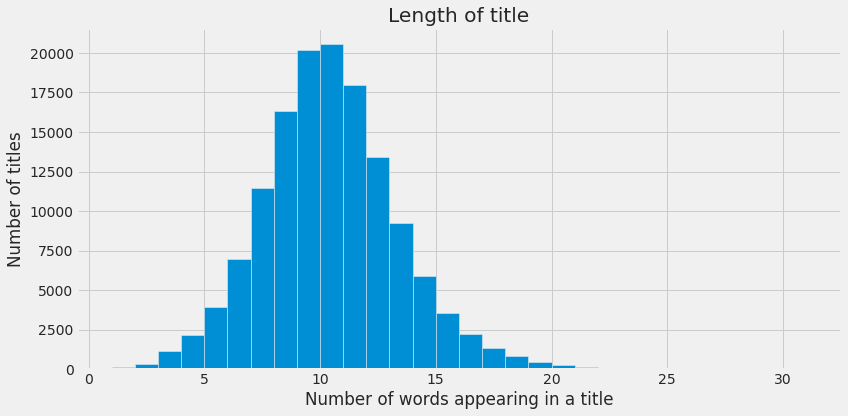

In [6]:
ax = titles["headline_wc"].plot(kind="hist", bins=30, fontsize=14, figsize=(12, 6))
ax.set_title("Length of title")
ax.set_xlabel('Number of words appearing in a title')
ax.set_ylabel('Number of titles')
plt.tight_layout()

In [7]:
print(f"The avg. number of words in a title are {titles.headline_wc.mean():.2f}")

The avg. number of words in a title are 9.96


Looks like normal to have 8-12 words per headlines.

### Extracting Keywords

In [8]:
from spacy.tokenizer import Tokenizer
from spacy.lang.en import English
from gensim.parsing.preprocessing import STOPWORDS

nlp = spacy.load('en_core_web_lg')
tokenizer = Tokenizer(nlp.vocab)

STOPWORDS = set(nlp.Defaults.stop_words.union(STOPWORDS)) # combine gensim + spacy
STOPWORDS = STOPWORDS.union(articles["publication"].unique().tolist()) # remove publication names from the headlines
STOPWORDS = STOPWORDS.union(["new", "york", "times"]) # add new york times
print(f"Length of STOPWORDS: {len(STOPWORDS)}")

Length of STOPWORDS: 377


In [9]:
def get_lemmas(text):
    text = text.strip()
    lemma_list = []
    if len(text) > 3:
        for token in tokenizer(text):
            lemma_list.append(token.lemma_)
    return lemma_list

get_lemmas("study studies studying cries cry crying")

['study', 'study', 'study', 'cry', 'cry', 'cry']

Always its handy to debug and test our your tokenizer to make sure it does what you exepect before doing computational intensive task.

### Overall trends

We will use Count Vectorizer to understand news trends over the years.

In [10]:
def get_cv_bow(docs, max_features=1000, ngram=2):
    """ Returns sorted CV vectors with feature names"""
    cv = CountVectorizer(tokenizer=get_lemmas, ngram_range=(ngram,ngram), max_features=max_features, stop_words=STOPWORDS, strip_accents='ascii')
    dtm = cv.fit_transform(docs)
    return pd.Series(np.array(dtm.sum(axis=0))[0],index=cv.get_feature_names()).sort_values(ascending=False)

In [11]:
def get_tfidf_bow(docs, max_features=1000, ngram=2):
    """ Returns sorted TF-IDF vectors with feature names"""
    tfidf = TfidfVectorizer(tokenizer=get_lemmas, ngram_range=(ngram,ngram), max_features=max_features, stop_words=STOPWORDS, strip_accents='ascii')
    dtm = tfidf.fit_transform(docs)
    return pd.Series(np.array(dtm.sum(axis=0))[0],index=tfidf.get_feature_names()).sort_values(ascending=False)

#### Unigrams

In [12]:
all_unigrams = get_cv_bow(titles.cleaned_title.values, ngram=1)

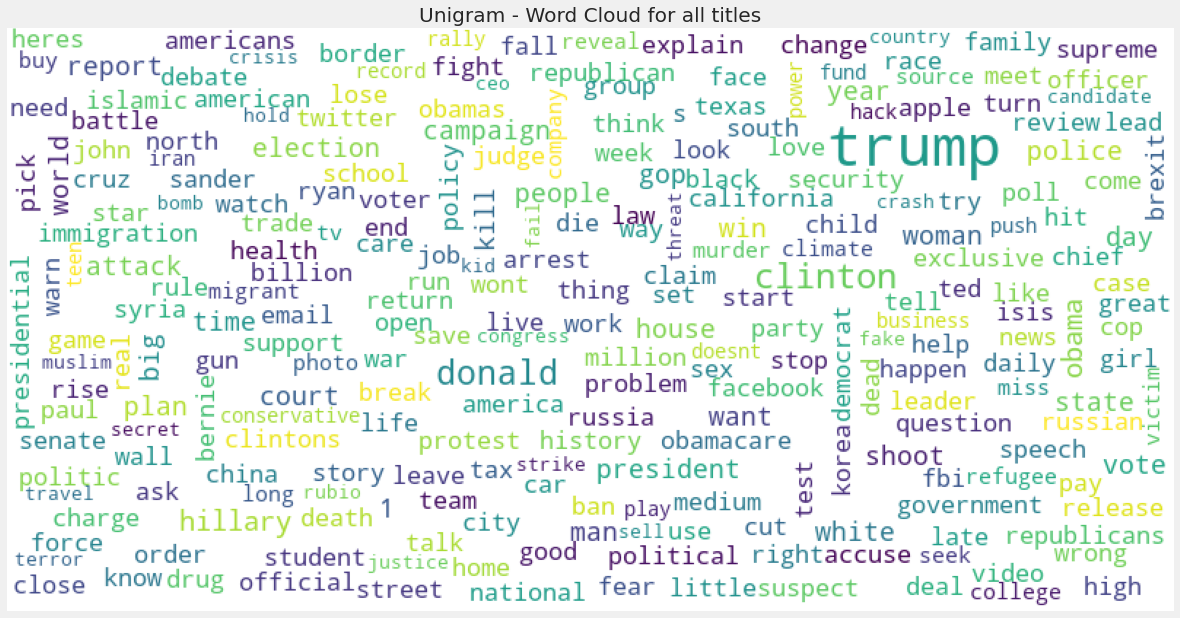

In [13]:
wordcloud = WordCloud(
       background_color='white',
       max_words=250,
       max_font_size=40,
       width=800,
       height=400).generate_from_frequencies(all_unigrams)
fig = plt.figure(figsize=(20,10))
plt.imshow(wordcloud)
plt.title("Unigram - Word Cloud for all titles")
plt.axis('off')
plt.show()

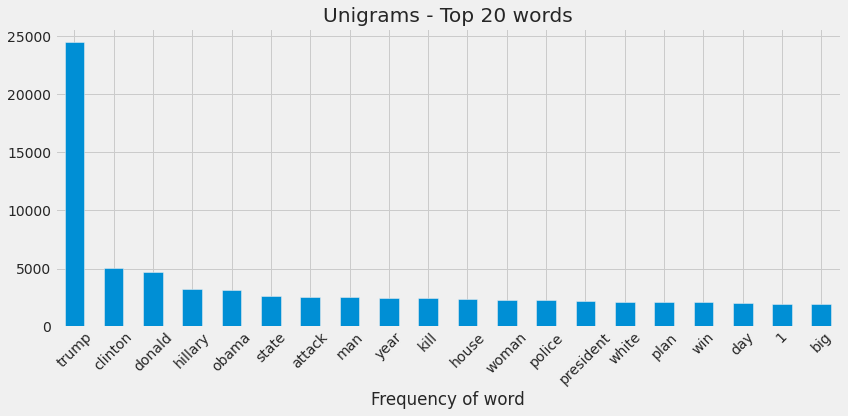

In [14]:
ax = all_unigrams.head(20).plot(kind='bar', fontsize=14, figsize=(12, 6))
ax.set_title("Unigrams - Top 20 words")
ax.set_xlabel('Frequency of word')
ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
plt.tight_layout()

In [15]:
all_unigrams.head(20)

trump        24488
clinton       5071
donald        4721
hillary       3207
obama         3127
state         2659
attack        2588
man           2582
year          2488
kill          2455
house         2373
woman         2290
police        2276
president     2184
white         2121
plan          2084
win           2073
day           2011
﻿1            1975
big           1951
dtype: int64

We can see majority of articles are geo-political issue, and some related to war and crime. We don't get much information from this let's look at bigrams.

#### Bigrams

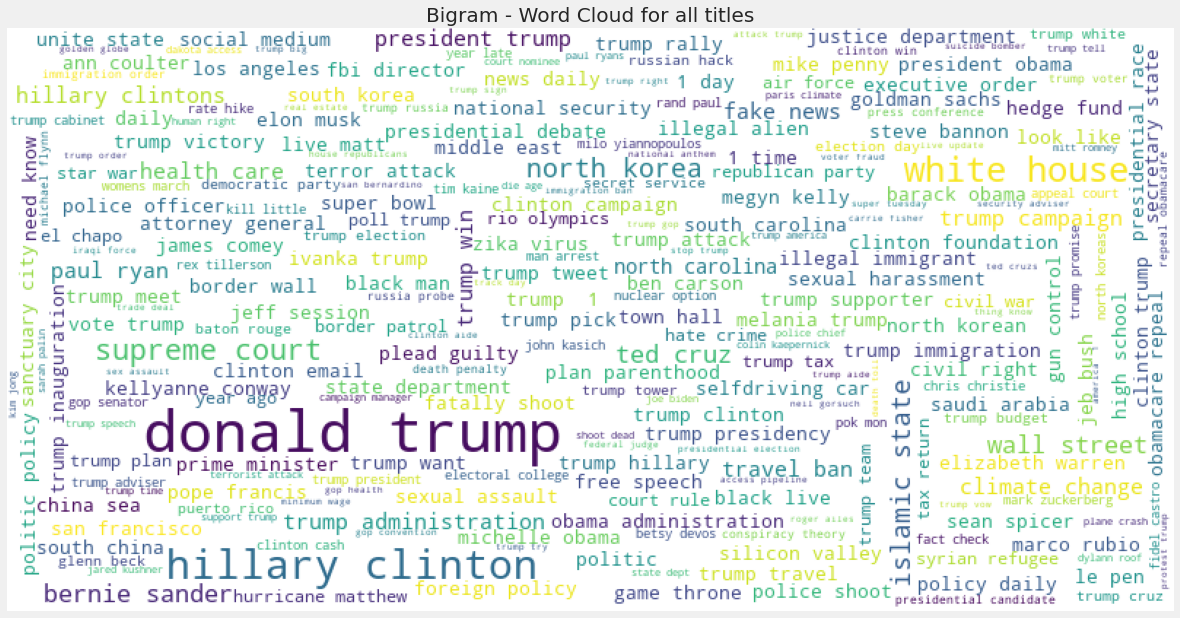

In [16]:
all_bigrams = get_cv_bow(titles.cleaned_title.values)
wordcloud = WordCloud(
       background_color='white',
       max_words=250,
       max_font_size=40,
       width=800,
       height=400).generate_from_frequencies(all_bigrams)
fig = plt.figure(figsize=(20,10))
plt.imshow(wordcloud)
plt.title("Bigram - Word Cloud for all titles")
plt.axis('off')
plt.show()

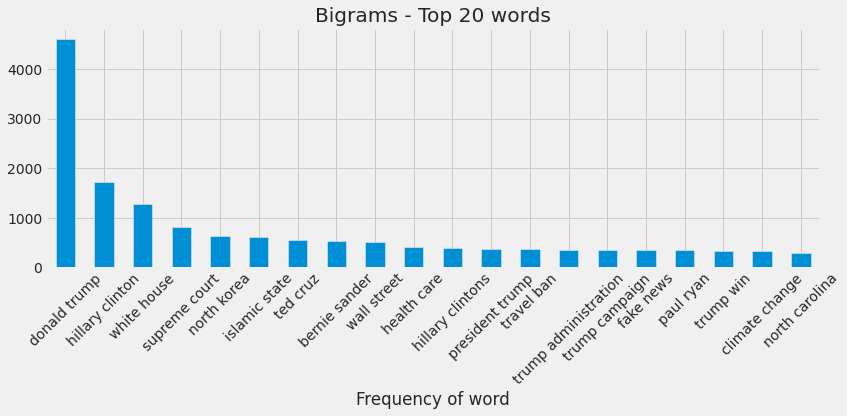

In [17]:
ax = all_bigrams.head(20).plot(kind='bar', fontsize=14, figsize=(12, 6))
ax.set_title("Bigrams - Top 20 words")
ax.set_xlabel('Frequency of word')
ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
plt.tight_layout()

Now with bigrams we have better idea, what the topics are, `donald trump`, `climate change`, `trump presidency`, `islamic state`, `clinton foundation`, `ted cruz`, `zika virus`, `el chapo`, `north korea`, `megyn kelly` etc...

#### Trigrams

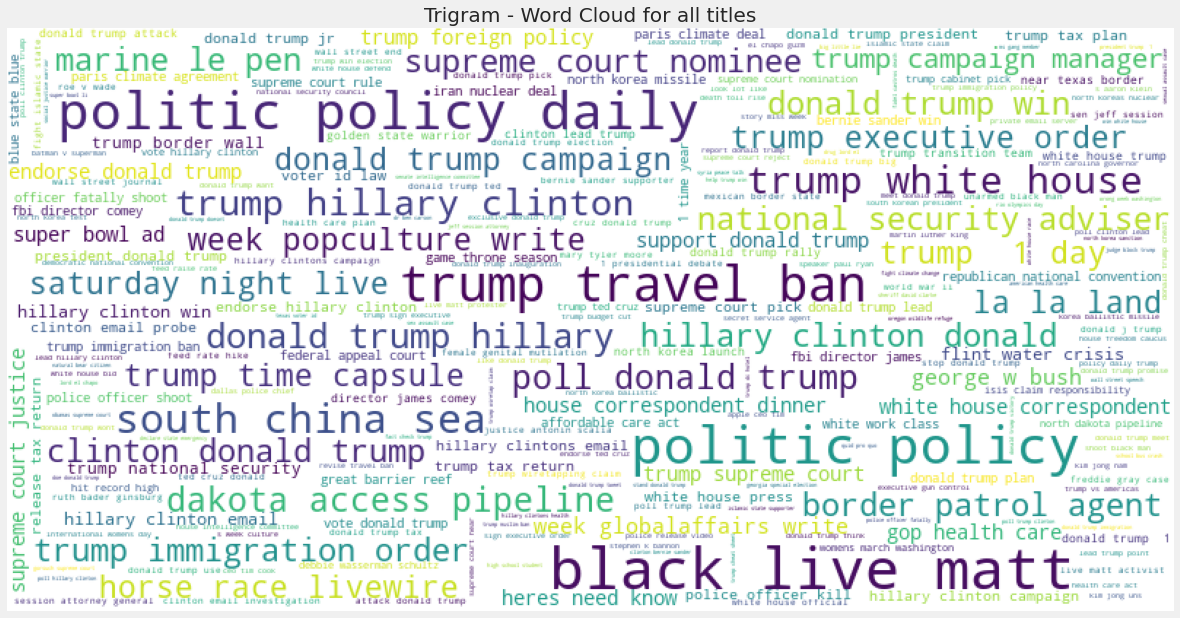

In [18]:
all_trigrams = get_cv_bow(titles.cleaned_title.values, ngram=3)
wordcloud = WordCloud(
       background_color='white',
       max_words=250,
       max_font_size=40,
       width=800,
       height=400).generate_from_frequencies(all_trigrams)
fig = plt.figure(figsize=(20,10))
plt.imshow(wordcloud)
plt.title("Trigram - Word Cloud for all titles")
plt.axis('off')
plt.show()

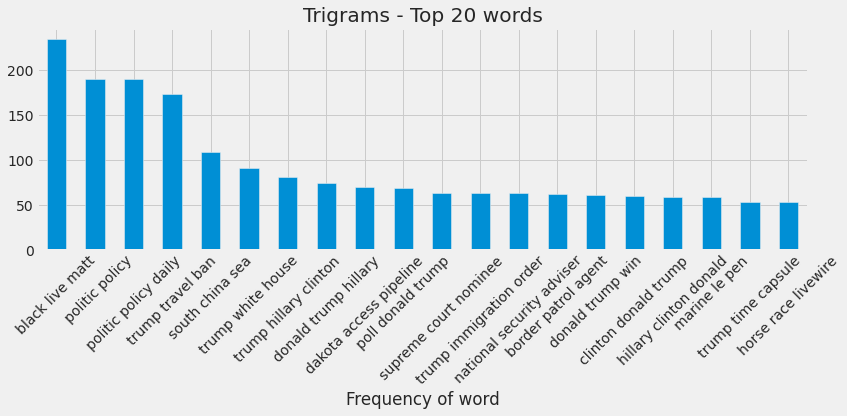

In [19]:
ax = all_trigrams.head(20).plot(kind='bar', fontsize=14, figsize=(12, 6))
ax.set_title("Trigrams - Top 20 words")
ax.set_xlabel('Frequency of word')
ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
plt.tight_layout()

Now with trigrams we can tell in more detail about what was the most talked about news events werem, for e.g.

- Geo-political events that happened - south china sea, trump travel ban, ...
- Socio-political events that happened - black lives matter, ...


### Trends by year - bigram and trigram

In [20]:
# Extract bigrams by year
bigrams_by_yr = {}
for yr in titles.date.dt.year.unique():
    docs = titles[titles.date.dt.year == yr]['cleaned_title'].tolist()
    bigrams_by_yr[yr] = get_cv_bow(docs, ngram = 2)

### Top 20 bigrams across years - 2015, 2016 & 2017

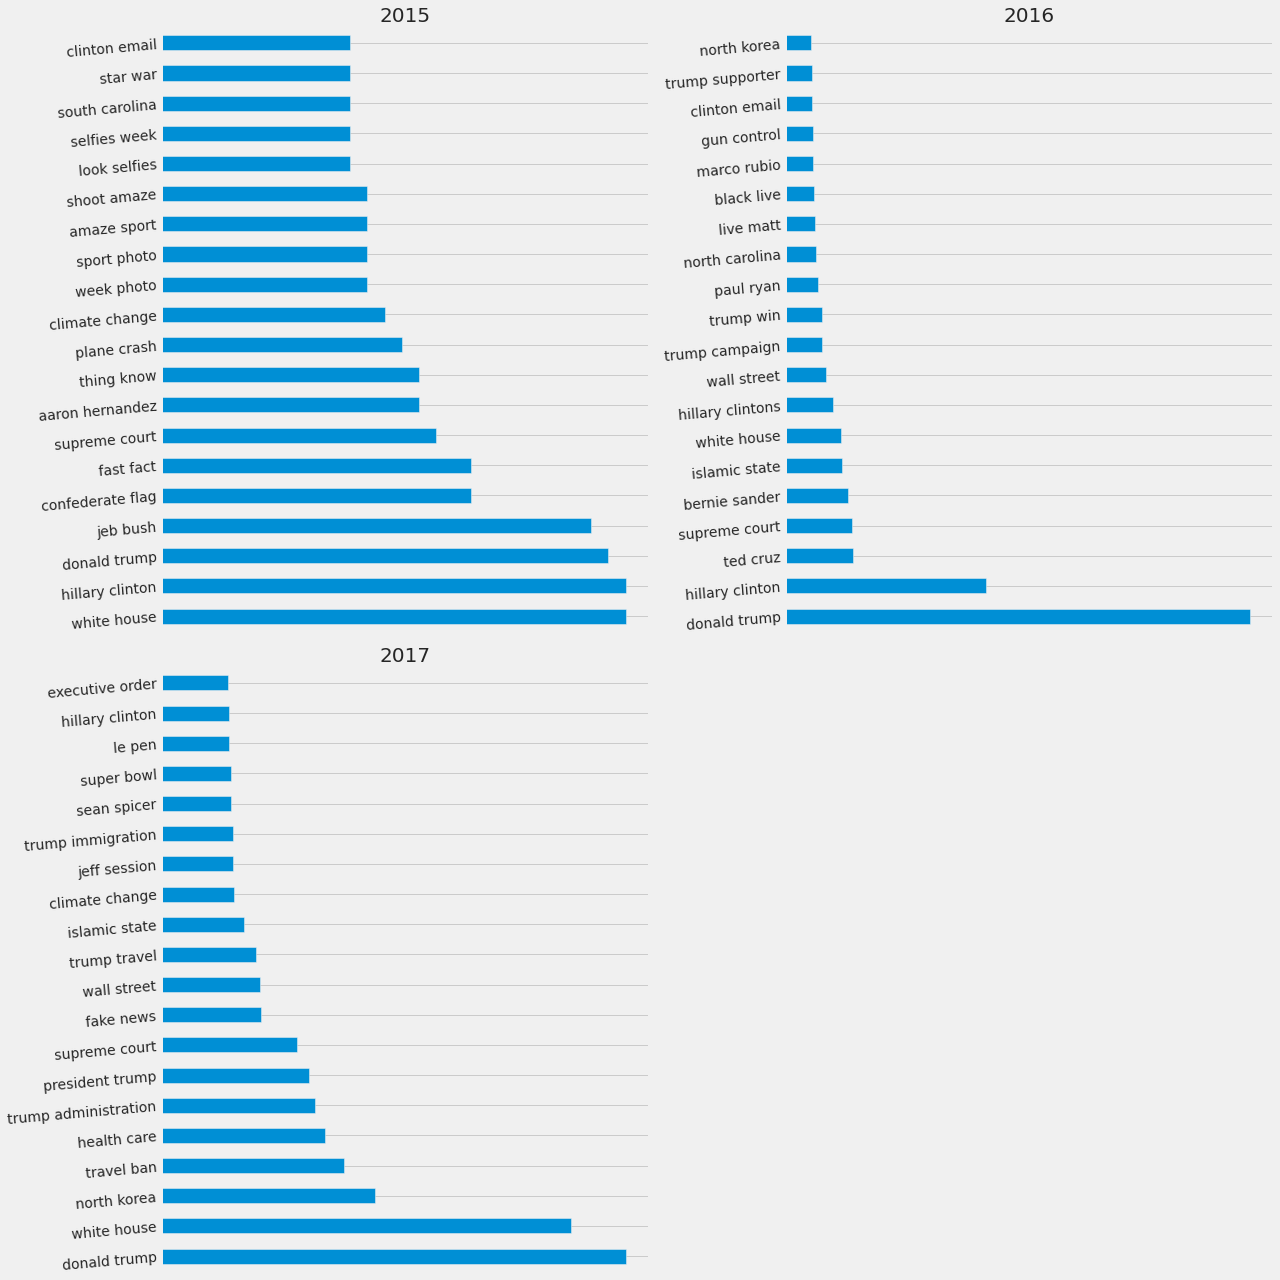

In [21]:
plt.figure(figsize=(18, 18))
for i in range(1, 4):
    plt.subplot(2, 2, i)
    bigrams_by_yr[2014+i].head(20).plot(kind="barh", fontsize=14)
    plt.title(2014+i, fontsize=20)
    plt.yticks(rotation=5)
    plt.xticks([])
    plt.tight_layout()

Some of the things are quite aparent, for e.g. in 

- 2015
   - competition between trump, jeb bush and hillary clinton for POTUS
   - aaron hernandez - NFL player that was arrested and was on trial
   - star wars movie was released
   - clinton email scandal
   - somehow selfies were becoming popular
   
- 2016
    - gun control debate that happend due to north carolina shooting
    - islamic state - ISIS 
    - election year, and trump won 
    - black lives matter protest
   
- 2017
    - travel ban
    - again islamic state
    - jeff session
    - sean spicer
    - super bowl ads
    
    
Now let's move on to analyzing trigrams this will gives us more context to what this issues were.

### Top 20 trigrams across years - 2015, 2016 & 2017

In [22]:
# Extract trigrams by year
trigrams_by_yr = {}
for yr in titles.date.dt.year.unique():
    docs = titles[titles.date.dt.year == yr]['cleaned_title'].tolist()
    trigrams_by_yr[yr] = get_cv_bow(docs, ngram = 3)

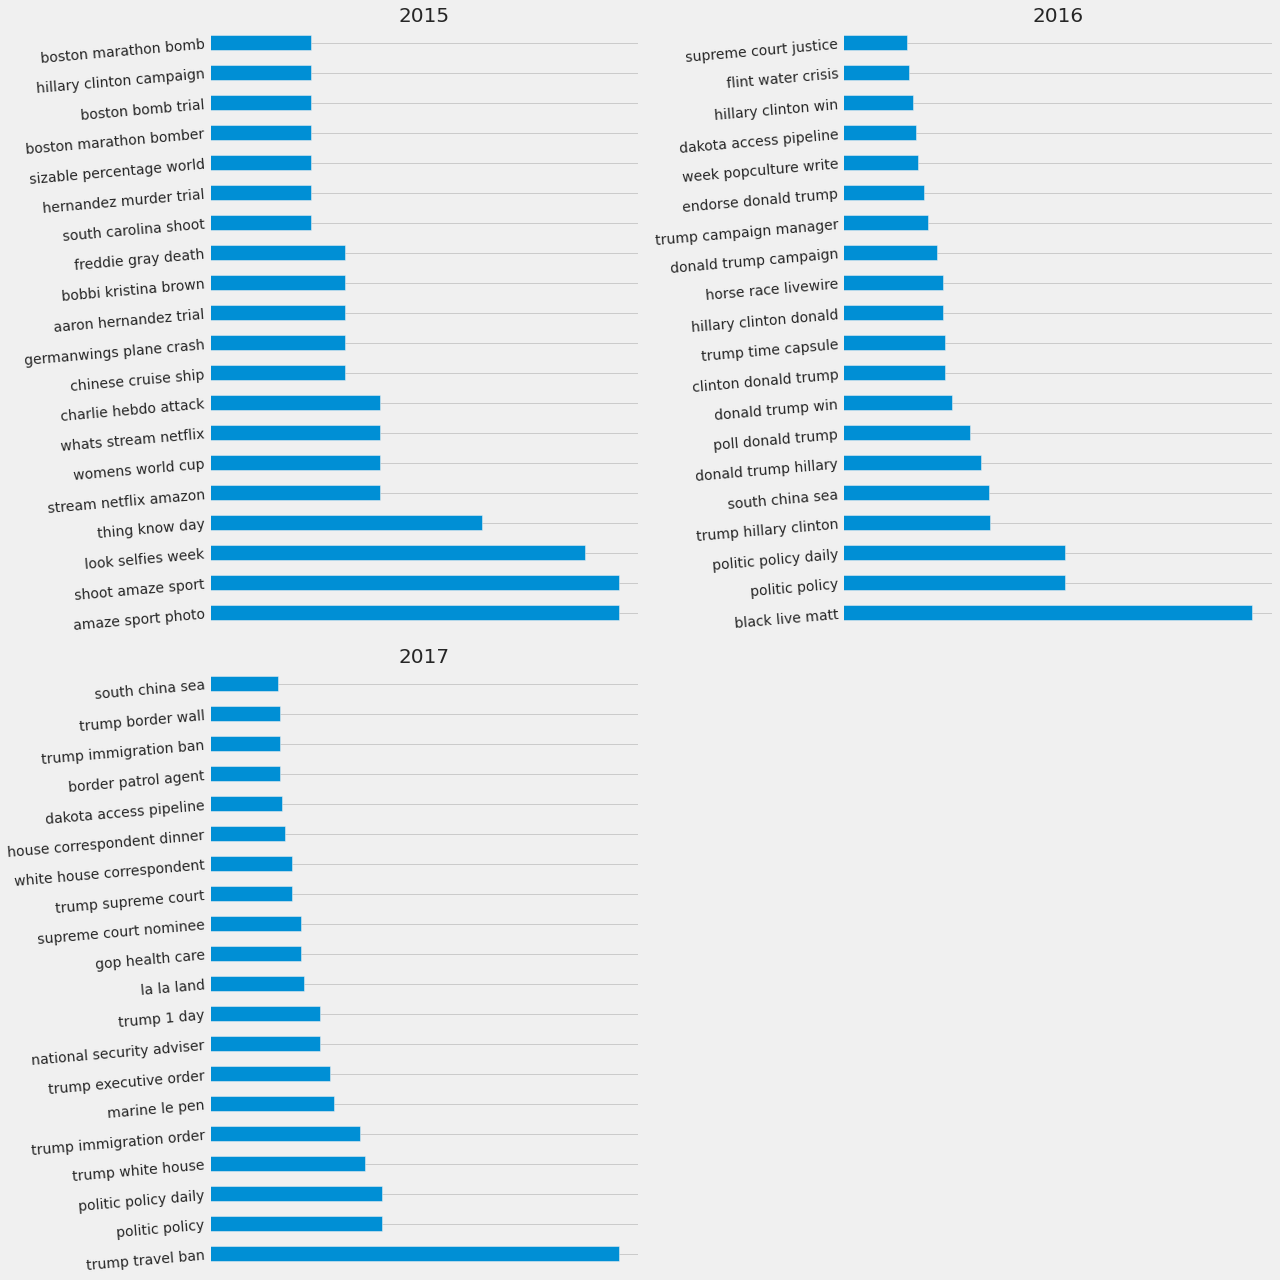

In [23]:
plt.figure(figsize=(18, 18))
for i in range(1, 4):
    plt.subplot(2, 2, i)
    trigrams_by_yr[2014+i].head(20).plot(kind="barh", fontsize=14)
    plt.title(2014+i, fontsize=20)
    plt.yticks(rotation=5)
    plt.xticks([])
    plt.tight_layout()

Wow! Now we have much clear idea on most of the major events that happened, from 2015 boston bomb trials, charlie hebdo attack, aaron hernandez trial, south china sea issue, vs. 2016 flint water crisis, black lives matter movement. 

Now let's look at which news stories where consistenly reported over the years, one can expect any news related Donald Trump or Clinton would have been reported, while it would be interesting thing to see which other news stories were reported. 

### Common bigrams across years - 2015, 2016 & 2017

In [24]:
### Common bigrams across all the years
common_bigrams = {}
for yr in range(2015, 2017):
    if yr == 2015:
        common_bigrams[yr] = set(bigrams_by_yr[yr].index).intersection(set(bigrams_by_yr[yr + 1].index))
    else:
        common_bigrams[yr] = common_bigrams[yr - 1].intersection(set(bigrams_by_yr[yr + 1].index))
        
        
### Common trigrams across all the years
common_trigrams = {}
for yr in range(2015, 2017):
    if yr == 2015:
        common_trigrams[yr] = set(trigrams_by_yr[yr].index).intersection(set(trigrams_by_yr[yr + 1].index))
    else:
        common_trigrams[yr] = common_trigrams[yr - 1].intersection(set(trigrams_by_yr[yr + 1].index))
        
        
## Count of common tokens across the years
count_common_bi={}
for year in range(2015, 2017):
    count_common_bi[year] = pd.Series()
    for word in common_bigrams[year]:
        if year == 2015:
            count_common_bi[year][word] = bigrams_by_yr[year][word]+ bigrams_by_yr[year + 1][word]
        else:
            count_common_bi[year][word] = count_common_bi[year - 1][word] + bigrams_by_yr[year + 1][word]

count_common_tri={}
for year in range(2015, 2017):
    count_common_tri[year] = pd.Series()
    for word in common_trigrams[year]:
        if year == 2015:
            count_common_tri[year][word] = trigrams_by_yr[year][word] + trigrams_by_yr[year + 1][word]
        else:
            count_common_tri[year][word] = count_common_tri[year - 1][word] + trigrams_by_yr[year + 1][word]

#### Top 20 bigrams across years

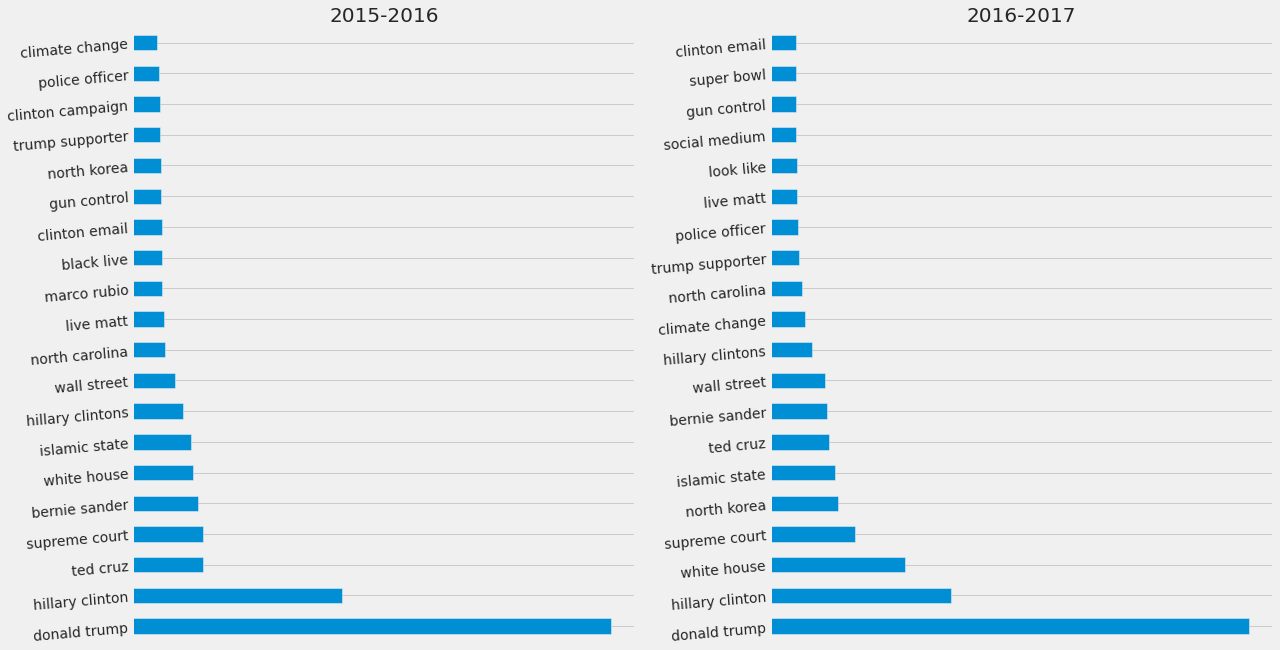

In [25]:
plt.figure(figsize=(18, 18))
for i in range(1, 3):
    plt.subplot(2, 2, i)
    count_common_bi[2014+i].sort_values(ascending=False).head(20).plot(kind="barh", fontsize=14)
    plt.title(f"{2014+i}-{2014+1+i}", fontsize=20)
    plt.yticks(rotation=5)
    plt.xticks([])
    plt.tight_layout()

Most of this issues are consistent over time, for e.g. - gun control debates due to major shootings that happened from 2015-2017.

#### Top 20 trigrams across years

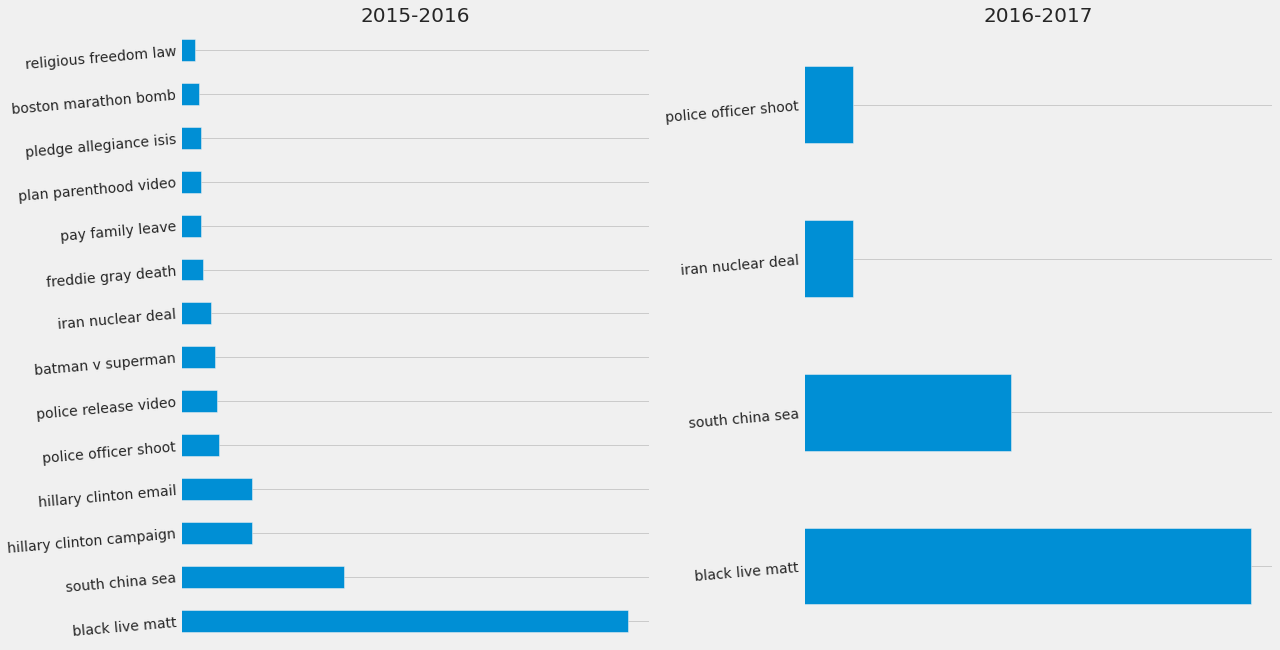

In [26]:
plt.figure(figsize=(18, 18))
for i in range(1, 3):
    plt.subplot(2, 2, i)
    count_common_tri[2014+i].sort_values(ascending=False).head(20).plot(kind="barh", fontsize=14)
    plt.title(f"{2014+i}-{2014+1+i}", fontsize=20)
    plt.yticks(rotation=5)
    plt.xticks([])
    plt.tight_layout()

With trigrams we can see `South China Sea` and `Black Lives Matter` where most talked about common issues from 2015-2017.

### Lockheed Martin & it's Competitors

Given the dataset is large, let's narrow down the focus to Lockheed and it's competitors to understand any strategic business decision that can be made. 

Given the span of what lockheed does in Aerospace and Defense, we can narrow down the list to its top most competitors.

Top competitors of lockheed are: 

- Boeing
- Northrop Grumman
- Raytheon 
- General Dynamics
- Space X (mostly a competitor of ULA)

#### Tech Companies, Suppliers, and Partners

While I don't have a list of names for suppliers, we can use keywords like `Aerospace` that would help filter out more relevant articles as most companies use the word `Aerospace` as a suffix.


In [27]:
filtered_articles = articles[(articles["cleaned_title"].str.contains("lockheed")) | (articles["cleaned_title"].str.contains("boeing")) | (articles["cleaned_title"].str.contains("raytheon")) | articles["cleaned_title"].str.contains("general dynamics") | (articles["cleaned_title"].str.contains("northrop grumman")) | ((articles["cleaned_title"].str.contains("aerospace")))]
filtered_articles.head()

title     publication  \
1329  Trump Talk Rattles Aerospace Industry, Up and ...  new york times   
2298  Trump Faces Test as Boeing Announces Deal to S...  new york times   
4928  Iran and Boeing Sign $16.6 Billion Deal on Sal...  new york times   
7238  Iran Said to Have Deal With Boeing to Buy Pass...  new york times   
8008  Lockheed CEO Pledges 1,800 New Jobs, Lower F-3...       breitbart   

           date                                            content  \
1329 2017-02-24  CHEHALIS, Wash. — At this small factory south ...   
2298 2017-04-05  The Boeing Company announced a tentative agree...   
4928 2016-12-12  TEHRAN — Iran and Boeing signed a deal for the...   
7238 2016-06-15  Iran has reached an agreement with the Boeing ...   
8008 2017-01-13  The CEO of the aerospace defense company Lockh...   

                                        cleaned_content  \
1329  chehalis wash at this small factory south of s...   
2298  the boeing company announced a tentative agree...   
4928  tehran iran and boeing signed a deal for the s...   
7238  iran has reached an agreement with the boeing ...   
8008  the ceo of the aerospace defense company lockh...   

                                          cleaned_title  
1329  trump talk rattles aerospace industry up and d...  
2298  trump faces test as boeing announces deal to s...  
4928  iran and boeing sign billion deal on sale of a...  
7238  iran said to have deal with boeing to buy pass...  
8008        lockheed ceo pledges new jobs lower f costs

In [28]:
print(f"Total articles remaining are: {len(filtered_articles)}") 

Total articles remaining are: 117


While the corpora is small, we should be able to get a proof of concept and gain some insights.

### Extract Keywords using TF-IDF

In [29]:
STOPWORDS = STOPWORDS.union(["mr"]) 

In [30]:
def get_tfidf_bow(docs, max_features=1000, ngram=2):
    """ Returns sorted TF-IDF vectors with feature names"""
    tfidf = TfidfVectorizer(tokenizer=get_lemmas, ngram_range=(ngram,ngram), max_features=max_features, stop_words=STOPWORDS, strip_accents='ascii')
    dtm = tfidf.fit_transform(docs)
    return pd.Series(np.array(dtm.sum(axis=0))[0],index=tfidf.get_feature_names()).sort_values(ascending=False)

In [32]:
def print_results(df, col_name, idx):  
    row = df.iloc[idx]
    keywords = get_tfidf_bow([row[col_name]], ngram=1).head(10)
    
    print("\n=====Title=====")
    print(row["title"])
    
    print("\n=====Body=====")
    print(row["content"][:300])
    
    print("\n===Keywords===")
    print(keywords)
    
print_results(filtered_articles, "cleaned_content", 1)


=====Title=====
Trump Faces Test as Boeing Announces Deal to Sell Jetliners to Iran - The New York Times

=====Body=====
The Boeing Company announced a tentative agreement on Tuesday to sell up to 60 737s to an Iranian airline, a transaction valued at $6 billion that angered American critics of Iran and appeared likely to test the Trump administration’s avowed hostility toward that country. Boeing, a leading commercia

===Keywords===
iran         0.422368
boeing       0.322988
trump        0.298142
aircraft     0.223607
agreement    0.198762
american     0.198762
deal         0.173916
iranian      0.149071
announce     0.149071
country      0.149071
dtype: float64


We can see the keyword are incredibly useful in indexing the news articles and helping us filter out related articles.

### Generate keywords

In [33]:
def generate_keywords(text):
    keywords = get_tfidf_bow([text], ngram=1).head(10)
    keywords = np.unique(keywords.index) 
    return keywords

filtered_articles["keywords"] = filtered_articles["cleaned_content"].progress_apply(generate_keywords)
filtered_articles.sample(10)

100%|██████████| 117/117 [00:01<00:00, 75.35it/s]


title       publication  \
57655   Iran says Boeing officials will visit Tehran soon          fox news   
45658   A Ukrainian plane company is threatening to ov...  business insider   
49357   Iran negotiated to pay only half price for its...  business insider   
2298    Trump Faces Test as Boeing Announces Deal to S...    new york times   
49302   After meeting with Trump, Boeing CEO says Air ...  business insider   
114873  Boeing to lay off hundreds more engineers: source           reuters   
122467  Trump attack on Lockheed Martin foreshadows wa...           reuters   
46820   Russia just unveiled its new Airbus and Boeing...  business insider   
49314   Trump asks Boeing to price out a comparable je...  business insider   
29175   Donald Trump Floats Boeing Proposal to Counter...         breitbart   

             date                                            content  \
57655  2016-04-09  Iran’s official IRNA news agency is saying a d...   
45658  2016-03-05  ’’ ’’ ’Lockheed Martin’ ’Last month, we relaye...   
49357  2016-12-26  ’ ’ ’ DUBAI (Reuters) Iran said on Sunday it h...   
2298   2017-04-05  The Boeing Company announced a tentative agree...   
49302  2016-12-22  ’’ ’WASHINGTON, DC — US Donald Trump on Wednes...   
114873 2017-04-18  Boeing Co warned employees on Monday it planne...   
122467 2016-12-13  Donald Trump on Monday widened his attack on d...   
46820  2016-06-09  ’’ ’The airliner market is getting more crowde...   
49314  2016-12-23  ’ ’ ’ WASHINGTON, DC — In response to a series...   
29175  2016-12-23  Lockheed Martin CEO Marillyn Hewson is seeing ...   

                                          cleaned_content  \
57655   irans official irna news agency is saying a de...   
45658   lockheed martin last month we relayed to you t...   
49357   dubai  iran said on sunday it had negotiated t...   
2298    the boeing company announced a tentative agree...   
49302   washington dc us donald trump on wednesday met...   
114873  boeing co warned employees on monday it planne...   
122467  donald trump on monday widened his attack on d...   
46820   the airliner market is getting more crowded al...   
49314   washington dc in response to a series of cost ...   
29175   lockheed martin ceo marillyn hewson is seeing ...   

                                            cleaned_title  \
57655   iran says boeing officials will visit tehran soon   
45658   a ukrainian plane company is threatening to ov...   
49357   iran negotiated to pay only half price for its...   
2298    trump faces test as boeing announces deal to s...   
49302   after meeting with trump boeing ceo says air f...   
114873   boeing to lay off hundreds more engineers source   
122467  trump attack on lockheed martin foreshadows wa...   
46820   russia just unveiled its new airbus and boeing...   
49314   trump asks boeing to price out a comparable je...   
29175   donald trump floats boeing proposal to counter...   

                                                 keywords  
57655   [airline, boeing, buy, iran, iranian, irans, i...  
45658   [antonov, build, carry, like, lockheed, market...  
49357   [aircraft, atr, billion, boeing, contract, ira...  
2298    [agreement, aircraft, american, announce, boei...  
49302   [air, boeing, contract, defense, force, little...  
114873  [airplane, boeings, company, employee, enginee...  
122467  [cost, defense, federal, fighter, jet, program...  
46820   [airliner, company, corp, introduce, irkut, ma...  
49314   [aircraft, cost, fighter, jet, lockheed, marti...  
29175   [cost, estimate, hewson, lockheed, martin, mee...

Now we have keywods which makes indexing the articles easy, next step is to used TF-IDF to see find similar articles using cosine similarity.

In [34]:
# 1. TIDF on entire corpus to vectorize the articles
tfidf = TfidfVectorizer(
    tokenizer=get_lemmas, 
    ngram_range=(1,1), 
    max_features=5000, 
    stop_words=STOPWORDS, 
    strip_accents='ascii'
)
dtm_tfidf = tfidf.fit_transform(filtered_articles["cleaned_content"].tolist())

In [35]:
# View Feature Matrix as DataFrame
dtm_tfidf_df = pd.DataFrame(dtm_tfidf.todense(),columns=tfidf.get_feature_names())
dtm_tfidf_df.head()

10    2        3    4    5    9  aac  abandon  abate     abbas  \
0  0.0  0.0  0.0  0.00000  0.0  0.0  0.0  0.0      0.0    0.0  0.000000   
1  0.0  0.0  0.0  0.03716  0.0  0.0  0.0  0.0      0.0    0.0  0.000000   
2  0.0  0.0  0.0  0.00000  0.0  0.0  0.0  0.0      0.0    0.0  0.061786   
3  0.0  0.0  0.0  0.00000  0.0  0.0  0.0  0.0      0.0    0.0  0.038385   
4  0.0  0.0  0.0  0.00000  0.0  0.0  0.0  0.0      0.0    0.0  0.000000   

   abccc  abedzadeh  abend  ability      able  aboard  aboulafia    abroad  \
0    0.0        0.0    0.0      0.0  0.024072     0.0   0.000000  0.033159   
1    0.0        0.0    0.0      0.0  0.000000     0.0   0.065538  0.000000   
2    0.0        0.0    0.0      0.0  0.000000     0.0   0.000000  0.000000   
3    0.0        0.0    0.0      0.0  0.000000     0.0   0.000000  0.000000   
4    0.0        0.0    0.0      0.0  0.000000     0.0   0.000000  0.000000   

   absolutely  absurdly  abu  accelerate  accept  acceptance  access  \
0         0.0       0.0  0.0         0.0     0.0         0.0     0.0   
1         0.0       0.0  0.0         0.0     0.0         0.0     0.0   
2         0.0       0.0  0.0         0.0     0.0         0.0     0.0   
3         0.0       0.0  0.0         0.0     0.0         0.0     0.0   
4         0.0       0.0  0.0         0.0     0.0         0.0     0.0   

   accessible  accident  acclaim  accommodate  accomplish    accord  \
0         0.0       0.0      0.0          0.0         0.0  0.000000   
1         0.0       0.0      0.0          0.0         0.0  0.019752   
2         0.0       0.0      0.0          0.0         0.0  0.000000   
3         0.0       0.0      0.0          0.0         0.0  0.000000   
4         0.0       0.0      0.0          0.0         0.0  0.000000   

   accordingly  account  accountability  accuracy  accusation  accuse  \
0          0.0      0.0             0.0       0.0         0.0     0.0   
1          0.0      0.0             0.0       0.0         0.0     0.0   
2          0.0      0.0             0.0       0.0         0.0     0.0   
3          0.0      0.0             0.0       0.0         0.0     0.0   
4          0.0      0.0             0.0       0.0         0.0     0.0   

   achieve  achievement  acknowledge   acquire  acquisition  act  action  \
0      0.0          0.0          0.0  0.000000      0.00000  0.0     0.0   
1      0.0          0.0          0.0  0.000000      0.00000  0.0     0.0   
2      0.0          0.0          0.0  0.000000      0.00000  0.0     0.0   
3      0.0          0.0          0.0  0.035281      0.03405  0.0     0.0   
4      0.0          0.0          0.0  0.000000      0.00000  0.0     0.0   

   actively  activity  actor  actual  actually  acute   ad  adam  adapt  \
0       0.0       0.0    0.0     0.0  0.034358    0.0  0.0   0.0    0.0   
1       0.0       0.0    0.0     0.0  0.000000    0.0  0.0   0.0    0.0   
2       0.0       0.0    0.0     0.0  0.000000    0.0  0.0   0.0    0.0   
3       0.0       0.0    0.0     0.0  0.000000    0.0  0.0   0.0    0.0   
4       0.0       0.0    0.0     0.0  0.000000    0.0  0.0   0.0    0.0   

        add  addition  additional  additive  address  adjudicate  adjust  \
0  0.056103       0.0    0.000000       0.0      0.0         0.0     0.0   
1  0.000000       0.0    0.022394       0.0      0.0         0.0     0.0   
2  0.000000       0.0    0.000000       0.0      0.0         0.0     0.0   
3  0.000000       0.0    0.000000       0.0      0.0         0.0     0.0   
4  0.000000       0.0    0.082923       0.0      0.0         0.0     0.0   

   adjustment  adjutant  adler  administration  admirably  admire  admirer  \
0         0.0       0.0    0.0        0.067713        0.0     0.0      0.0   
1         0.0       0.0    0.0        0.097646        0.0     0.0      0.0   
2         0.0       0.0    0.0        0.000000        0.0     0.0      0.0   
3         0.0       0.0    0.0        0.000000        0.0     0.0      0.0   
4         0.0       0.0    0.0     

### Cosine Similarity 

In [36]:
def find_similar_by_keywords(dtm_tfidf, tfidf, lookup, top_n=10):
    lookup = lookup.lower().strip()
    lookup_vec = tfidf.transform([lookup])
    similarity_score = lookup_vec @ dtm_tfidf.T
    vec = np.array(similarity_score.toarray()[0])
    indices = np.argsort(vec)[-top_n:][::-1]
    return indices

def print_search_results(lookup, indices, df):
    print('Prompt: ' + lookup)
    print('\n-------------------- Top 10 Similar Articles --------------------')
    for i in indices:
        print('title - {}'.format(df['title'].iloc[i]))
        
        
prompt =  "lockheed lost stock plummets"
results = find_similar_by_keywords(dtm_tfidf, tfidf, prompt)
print_search_results(prompt, results, filtered_articles)

Prompt: lockheed lost stock plummets

-------------------- Top 10 Similar Articles --------------------
title - Donald Trump Floats Boeing Proposal to Counter Lockheed Martin’s F-35 - Breitbart
title - Lockheed-Martin stock takes second hit from Trump’s Twitter blitz on F-35 costs
title - Trump: Boeing should lose Air Force One contract over ’out of control’ cost
title - Lockheed seals services deal with Leidos, forecasts profit below view
title - Trump asks Boeing to price-out ’comparable’ F-18 Super Hornet to Lockheed’s F-35
title - After Trump attack, Lockheed Martin slashes F-35 cost
title - Lockheed, Pentagon announce $8.5 billion F-35 order
title - Did Donald Trump tank Boeing’s stock because he was mad about a news article?
title - Trump pressures Lockheed, says told Boeing to price out fighter aircraft
title - Trump asks Boeing to price out a comparable jet to compete with F-35 — and Lockheed Martin’s stock tanked


😊 Perfect!, now we have a way to filter out articles based on keywords. Let's search try to find information on some of the competitors.

In [37]:
prompt =  "high cost boeing contract"
results = find_similar_by_keywords(dtm_tfidf, tfidf, prompt)
print_search_results(prompt, results, filtered_articles)

Prompt: high cost boeing contract

-------------------- Top 10 Similar Articles --------------------
title - After meeting with Trump, Boeing CEO says Air Force One will cost less than $4 billion
title - Trump rips Boeing for cost overruns on new Air Force One, says ’cancel order’
title - Lockheed Martin, Pentagon announce F-35 contract deal that shaves $728 million in costs
title - SpaceX Is Cribbing From Boeing’s 1920s Playbook
title - Pentagon, Lockheed finalize talks on ninth lot of F-35 jets
title - Iran negotiated to pay only half price for its $16.6 billion Boeing plane deal
title - Donald Trump Floats Boeing Proposal to Counter Lockheed Martin’s F-35 - Breitbart
title - SpaceX breaks Boeing-Lockheed monopoly on military space launches
title - Trump asks Boeing to price-out ’comparable’ F-18 Super Hornet to Lockheed’s F-35
title - Boeing CEO vows to build new Air Force One for less after Trump complaints


Great! we can see how it returns `boeing` related news articles that loosely match the prompt. Let's search a competitor in Space division.

In [38]:
prompt =  "spacex to launch military space satellites"
results = find_similar_by_keywords(dtm_tfidf, tfidf, prompt)
print_search_results(prompt, results, filtered_articles)

Prompt: spacex to launch military space satellites

-------------------- Top 10 Similar Articles --------------------
title - SpaceX breaks Boeing-Lockheed monopoly on military space launches
title - Boeing, Lockheed to launch habitats for space tourists and researchers
title - SpaceX Is Cribbing From Boeing’s 1920s Playbook
title - Boeing Suits Up for Future of Spaceflight with New Spacesuit Design - Breitbart
title - A Ukrainian plane company is threatening to overtake defense giant Lockheed Martin
title - At Boeing, Trump returns to an economic message after a week of controversy
title - At Boeing, Donald Trump Highlights ’Jobs First’ Agenda - Breitbart
title - Boeing aims for supersonics and Mars at outset of second century
title - Exclusive: Boeing near decision to launch 737-10 jet - sources
title - Singapore Airlines places $14 billion wide-body Boeing order


In [39]:
prompt =  "purchase of aerospace announced"
results = find_similar_by_keywords(dtm_tfidf, tfidf, prompt)
print_search_results(prompt, results, filtered_articles)

Prompt: purchase of aerospace announced

-------------------- Top 10 Similar Articles --------------------
title - Rockwell broadens its reach with $6.4 billion purchase of B/E Aerospace
title - Exclusive: Lockheed nears $37 billion-plus deal to sell F-35 jet to 11 countries
title - Iran negotiated to pay only half price for its $16.6 billion Boeing plane deal
title - Trump Faces Test as Boeing Announces Deal to Sell Jetliners to Iran - The New York Times
title - Boeing nears landmark deal to sell airliners to Iran
title - Exclusive: New Boeing 737 economy seat supplier books initial sales
title - Check out Delta’s new Canadian airliner that’s trying to challenge Boeing and Airbus
title - Boeing signs defense, commercial deals with Saudi Arabia
title - China’s CALC joins line-up for Boeing 737 MAX 10: sources
title - Iran and Boeing Sign $16.6 Billion Deal on Sale of 80 Aircraft - The New York Times


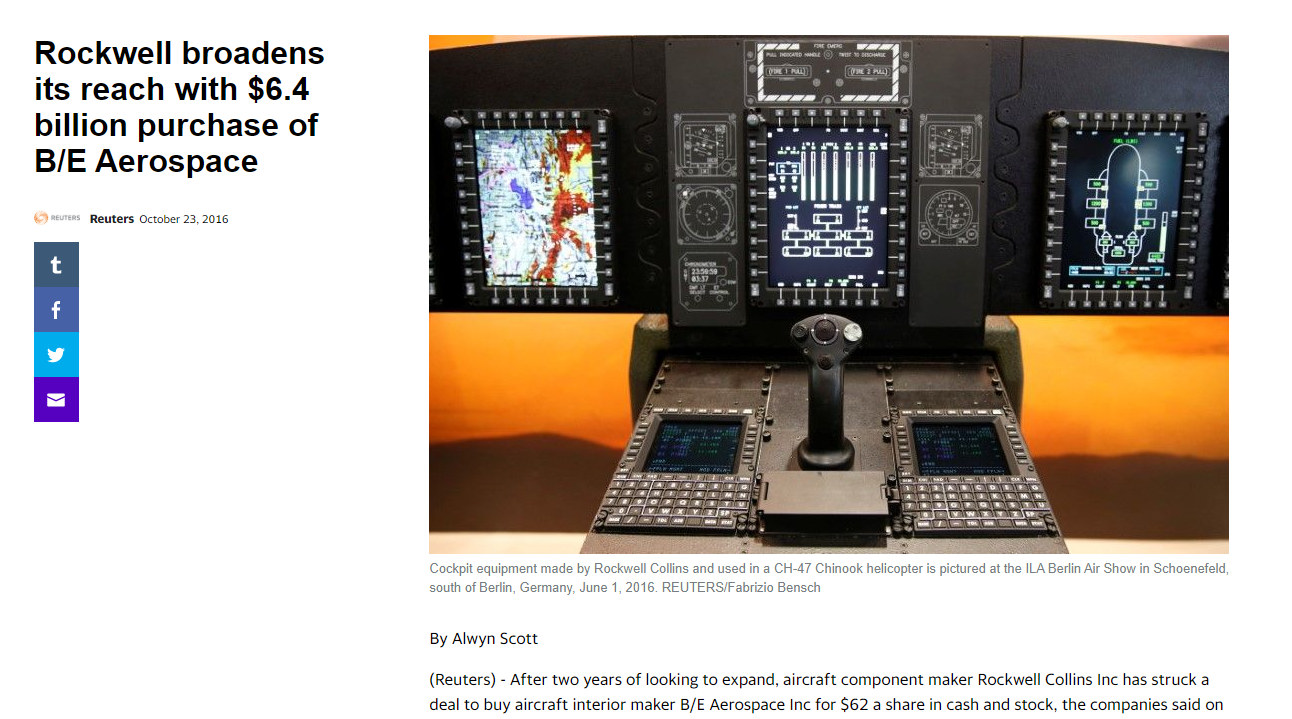

In [40]:
from IPython.display import Image
Image("https://i.imgur.com/cj6s3vA.png")

Awesome!, so now we have a tool that let's stakeholder to quickly find relevant articles and find similar articles given a prompt.

### Things we can do 

For **TF-IDF**:

- With keywords we can built we can use them as tags for the articles
- Create more robust custom filters to filter out Lockheed's suppliers, competitors, etc.., to filter the news
- Create web based application to monitor latest news
- While this dataset was skewed towards breitbart and new york post, more balanced dataset is needed
- Create custom stop words, and filter out any click bait news articles or advertisements
- Sort them by date and order of importance by using NER matching patterns

Investigate Word Embeddings:

One of the drawbacks of **TF-IDF**, while it's fast to train and deploy, it fails to capture semantic and sytantic similarity given a word with other words, compared to word embeddings. For example, there is strong association between words like `lockheed`, `aerospace`, `defense` `f35`, `boeing`, etc.., versus `disney`, `netflix`, etc. By leveraging word embedding based techinques we can find articles that match semantic similarity without loosing that information.